In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import spacy
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hansu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('../limpieza/comentarios_limpios.csv', dtype={'calificacion': 'int8', 'comentarios': 'string'})

def calificacion_to_sentimiento(puntaje):
    if puntaje >= 9:
        return 'positivo'
    elif puntaje >= 7:
        return 'neutro'
    else:
        return 'negativo'

In [3]:
import re
import string

df['comentarios'] = df['comentarios'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
df['sentimiento'] = df['calificacion'].apply(calificacion_to_sentimiento)

In [4]:
s_stp_w = set(stopwords.words('spanish'))
def f_stop_words(texto: str):
    p_filtradas = [p for p in texto.split() if p not in s_stp_w]
    return ' '.join(p_filtradas)

spacy_lema = spacy.load('es_core_news_lg')
def lematizar_texto(texto):
    doc = spacy_lema(texto)
    lemas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(lemas)

In [5]:
# df['c_wo_stp_ws'] = df['comentarios'].apply(f_stop_words)
df['c_wo_stp_ws'] = df['comentarios'].apply(lematizar_texto)

In [6]:
p = df['c_wo_stp_ws'].str.split().explode().unique()
len(p)

1203

In [ ]:
m_tf_idf = TfidfVectorizer(min_df=3, max_features=700)
vectores = m_tf_idf.fit_transform(df['c_wo_stp_ws'])
palabras = m_tf_idf.get_feature_names_out()

indice = 1719
vector = vectores[indice].toarray().flatten()

top_indices = np.where(vector > 0)[0]

for i in top_indices:
    print(f"{palabras[i]}: {vector[i]:.4f}")

print(df['comentarios'].iloc[indice])

agente: 0.3733
atento: 0.3024
carro: 0.3186
cm: 0.3421
entregar: 0.2532
hora: 0.3115
horario: 0.3226
malo: 0.2997
responder: 0.3421
servicio: 0.1695
unidad: 0.2234
muy informales te dicen un horario y el carro dos horas despues te lo entregan mi agente le llamas y no te responde para saber de tu unidad de verdad muy atento reo muy mala esperiencia en servicio 2cm


In [18]:
for sentimiento in df['sentimiento'].unique():
    subset = df[df['sentimiento'] == sentimiento]
    vectores_sent = TfidfVectorizer(max_df=0.50, ngram_range=(1,2)).fit_transform(subset['c_wo_stp_ws'])
    palabras_sent = TfidfVectorizer(max_df=0.50, ngram_range=(1,2)).fit(subset['c_wo_stp_ws']).get_feature_names_out()
    print(f"\npalabras comunes: {sentimiento}")
    tfidf_prom = vectores_sent.mean(axis=0).A1
    ranking = sorted(zip(palabras_sent, tfidf_prom), key=lambda x: x[1], reverse=True)
    for palabra, peso in ranking[:10]:
        print(f"{palabra}: {peso:.4f}")



palabras comunes: negativo
servicio: 0.0410
unidad: 0.0359
atencion: 0.0322
tiempo: 0.0211
entregar: 0.0186
malo: 0.0185
entrega: 0.0171
comunicacion: 0.0170
pesimo: 0.0170
lavado: 0.0166

palabras comunes: positivo
excelente: 0.0722
atencion: 0.0415
servicio: 0.0372
excelente servicio: 0.0196
perfecto: 0.0185
tiempo: 0.0132
excelente atencion: 0.0120
rapido: 0.0107
orden: 0.0102
entrega: 0.0098

palabras comunes: neutro
tiempo: 0.0466
entrega: 0.0444
atencion: 0.0360
tiempo entrega: 0.0333
servicio: 0.0269
unidad: 0.0237
precio: 0.0237
tardar: 0.0192
asesor: 0.0161
entregar: 0.0158


In [12]:
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_results = tsne.fit_transform(vectores.toarray())

In [14]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

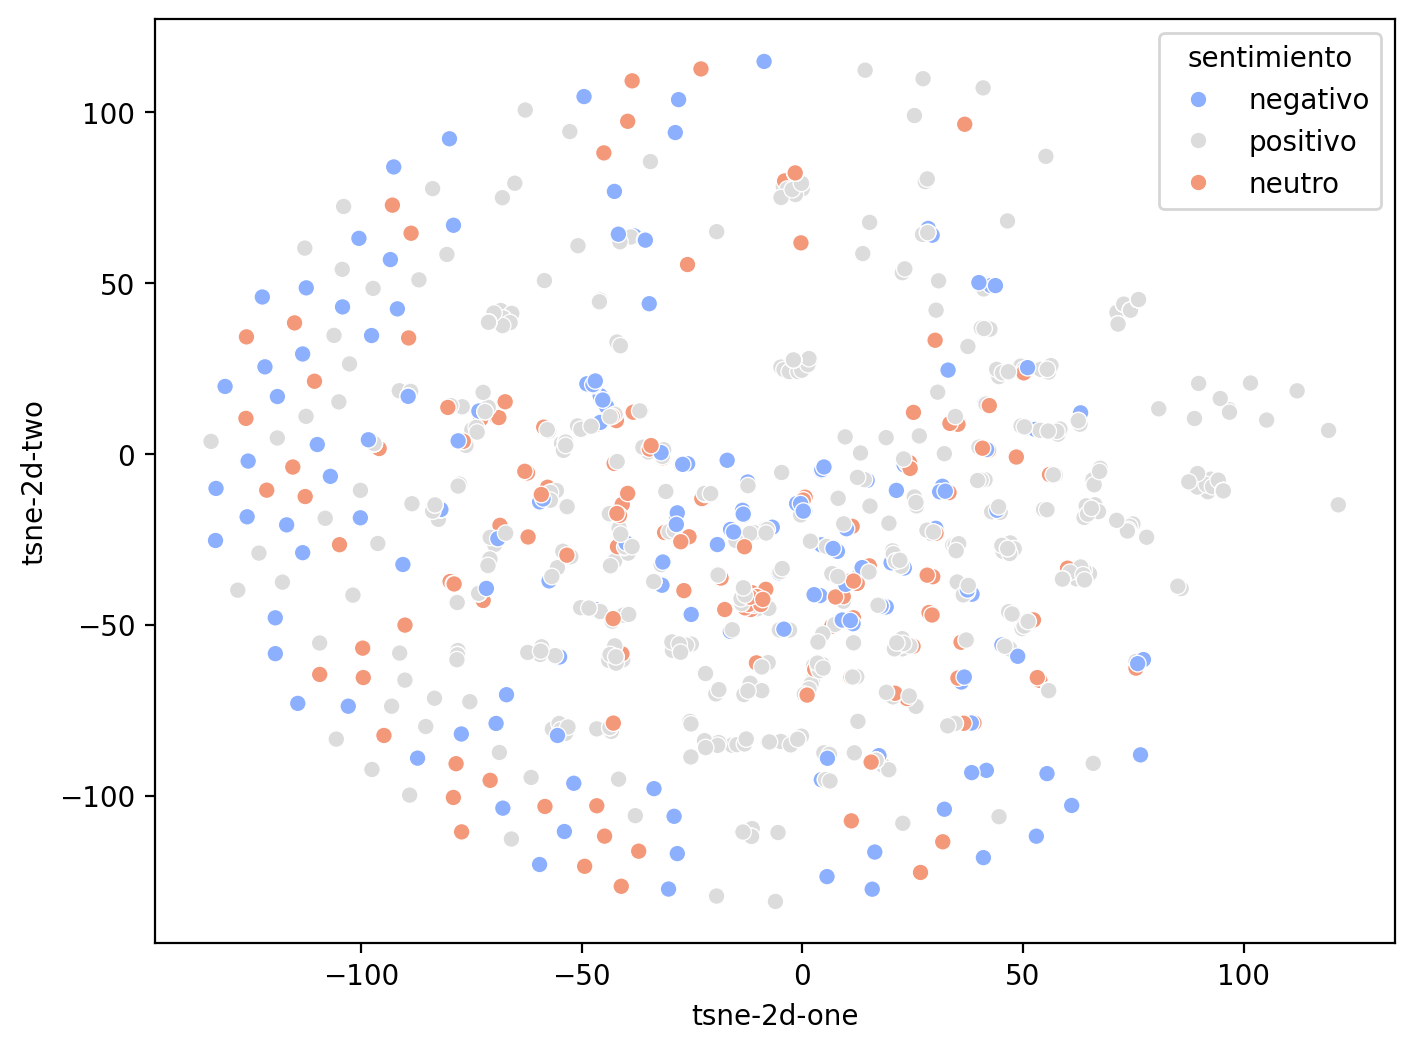

In [ ]:
plt.figure(figsize=(8,6), dpi=200)
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='sentimiento',
    palette='coolwarm',
    data=df,
    legend="full"
)
plt.show()